# This notebook was done by Taras Semenchenko

To run this notebook I used Google Colaboratory.


# Preparing data

To load data I used google drive, however dataset can be loaded without it.

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!sudo apt-get install unzip
!unzip 'drive/MyDrive/kyivstar/Geolife Trajectories 1.3.zip' -d 'geolife'

Loading pyspark library.

In [ ]:
# --- pyspark configuration ---

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!tar -xvf spark-3.0.1-bin-hadoop3.2.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"
import findspark
findspark.init()

# --- end of configuration ---

In [ ]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import Row

from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

from datetime import datetime

In the cell below the function, that loads all .plt files and labels.txt from specific directory `path` and creates 2 dataframes.
After loading data, it converts time to the unix_timestamp and performs `inner join` to add labels to the .plt data (It also leaves only data that contains labels).


In [ ]:
def folder_to_dataframe(path):
  file_location = path + '/Trajectory/*.plt'
  file_type = "csv"

  customSchema = StructType([
      StructField("latitude",    DoubleType(),  True),        
      StructField("longitude",   DoubleType(),  True),
      StructField("zeros",       IntegerType(), True),
      StructField("altitude",    DoubleType(),  True),
      StructField("num_of_days", DoubleType(),  True),
      StructField("date",        StringType(),  True),
      StructField("time",        StringType(),  True)
  ])

  df = spark.read.format(file_type) \
    .option('mode',        'DROPMALFORMED') \
    .option('inferSchema', 'true') \
    .option('header',      'false') \
    .option('sep',         ',') \
    .schema(customSchema) \
    .load(file_location)
    
  df_with_labels = df.withColumn("date_time", concat(col('date'), lit(' '), col('time')))
  df_unix_time = df_with_labels.withColumn("unix_time", unix_timestamp('date_time', 'yyyy-MM-dd HH:mm:ss'))

  file_location = path + "/labels.txt"
  file_type = "csv"

  customSchema = StructType([
      StructField("Start time",          StringType(), True),        
      StructField("End time",            StringType(), True),
      StructField("Transportation Mode", StringType(), True)
  ])

  df_labels = spark.read.format(file_type) \
    .option('inferSchema', 'true') \
    .option('header',      'true') \
    .option('sep',         '\t') \
    .schema(customSchema) \
    .load(file_location)

  df_labels_unix_time = df_labels.withColumn("unix_start", unix_timestamp('Start time', 'yyyy/MM/dd HH:mm:ss'))
  df_labels_unix_time = df_labels_unix_time.withColumn("unix_end", unix_timestamp('End time', 'yyyy/MM/dd HH:mm:ss'))

  df_with_labels = df_unix_time.join(df_labels_unix_time, 
          (df_labels_unix_time['unix_start'] <= df_unix_time['unix_time']) & 
          (df_unix_time['unix_time'] <= df_labels_unix_time['unix_end']), how='inner') \
    .select('latitude', 'longitude', 'zeros', 'altitude', 'num_of_days', 'date', 'time', 'date_time', 'Transportation Mode')
  
  df_with_labels = df_with_labels.withColumn("id", lit(path[-3:]))

  return df_with_labels

Looking for folders that contain labels.txt.

In [ ]:
import os

paths_with_labels = list()

for folder in os.listdir('geolife/Geolife Trajectories 1.3/Data'):
  if os.path.exists('geolife/Geolife Trajectories 1.3/Data/' + folder + '/labels.txt'):
    paths_with_labels += ['geolife/Geolife Trajectories 1.3/Data/' + folder]

Concatenation all dataframes that returns previous function.

In [ ]:
from tqdm.notebook import tqdm
full_df = folder_to_dataframe(paths_with_labels[0])

for path in tqdm(paths_with_labels[1:]):
  d = folder_to_dataframe(path)
  full_df = full_df.union(d)

Saving dataframe as .parquet to perform faster operations (it may take 15 minutes).

In [ ]:
# parquet format requires names without space
full_df = full_df.withColumnRenamed("Transportation Mode", "transportation_mode")
full_df.write.parquet("structured_geolife.parquet")

Loading data and showing the table:

In [ ]:
df = spark.read.parquet("structured_geolife.parquet")
df.show()

+---------+----------+-----+--------+----------------+----------+--------+-------------------+-------------------+---+
| latitude| longitude|zeros|altitude|     num_of_days|      date|    time|          date_time|transportation_mode| id|
+---------+----------+-----+--------+----------------+----------+--------+-------------------+-------------------+---+
|37.936471|114.500004|    0|   207.0|39719.6666666667|2008-09-28|16:00:00|2008-09-28 16:00:00|              train|010|
|37.936084|114.500086|    0|   207.0|39719.6666782407|2008-09-28|16:00:01|2008-09-28 16:00:01|              train|010|
|37.935304|114.500256|    0|   210.0|39719.6667013889|2008-09-28|16:00:03|2008-09-28 16:00:03|              train|010|
|37.934926|114.500368|    0|   207.0| 39719.666712963|2008-09-28|16:00:04|2008-09-28 16:00:04|              train|010|
|37.934543|114.500456|    0|   207.0| 39719.666724537|2008-09-28|16:00:05|2008-09-28 16:00:05|              train|010|
|37.934156|114.500543|    0|   207.0|39719.66673

In [116]:
df.count()

5509013

Distribution of classes:

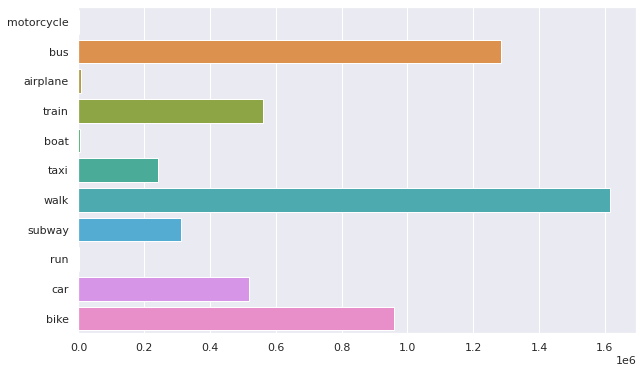

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

label_counts = df.groupBy('transportation_mode').count().collect()
labels = [row['transportation_mode'] for row in label_counts]
counts = [row['count'] for row in label_counts]

plt.figure(figsize=(10, 6))
sns.barplot(x=counts, y=labels);

# Feature extraction

I added the following features:
- hour - current hour (0 - 23)
- weekday - day of the week ('Mon', 'Tue', etc)
- day - day of the month (0 - 30)
- month - number of month (0 - 11)
- latitude_lag_5 - difference between current latitude and latitude 5 time-stamped points ago.
- longitude_lag_5 - difference between current longitude and longitude 5 time-stamped points ago.
- unix_time_lag_5 - difference between current unix_time and unix_time 5 time-stamped points ago.
- distance_lag_5 - distance that a person covered in 5 time-stamped points.
- speed_lag_5 - speed of the person, which equal to distance_lag_5 / unix_time_lag_5.

In [97]:
processed_df = df.withColumn("id", df["id"].cast(IntegerType()))
processed_df = processed_df.withColumn('unix_time', unix_timestamp(col('date_time')))

processed_df = processed_df.withColumn('hour', date_format('date_time', 'H').cast(IntegerType()))
processed_df = processed_df.withColumn('weekday', date_format('date_time', 'E'))
processed_df = processed_df.withColumn('day', date_format('date_time', 'd').cast(IntegerType()))
processed_df = processed_df.withColumn('month', month('date_time').cast(IntegerType()))

I chose the size of the time window equal to 5, as I think that  to accurately calculate the speed should pass at least 5 seconds

In [98]:
from pyspark.sql.window import Window
windowSpec  = Window.partitionBy("id").orderBy("unix_time")

processed_df = processed_df.withColumn("latitude_lag_5", col('latitude') - lag("latitude", 5).over(windowSpec))
processed_df = processed_df.withColumn("longitude_lag_5", col('longitude') - lag("longitude", 5).over(windowSpec))
processed_df = processed_df.withColumn("unix_time_lag_5", col('unix_time') - lag("unix_time", 5).over(windowSpec))

processed_df = processed_df.withColumn("distance_lag_5", sqrt(col('latitude_lag_5') ** 2 + col('longitude_lag_5') ** 2))
processed_df = processed_df.withColumn("speed_lag_5", col('distance_lag_5') / col('unix_time_lag_5'))

To handle missing values I filled it with value -999999. (Random Forest work with it well)

In [99]:
processed_df = processed_df.fillna({
    'latitude_lag_5': -999999, 
    'longitude_lag_5': -999999, 
    'unix_time_lag_5': -999999, 
    'distance_lag_5': -999999, 
    'speed_lag_5': -999999,
})

In [100]:
num_features = [
  'id', 
  'latitude', 
  'longitude', 
  'altitude', 
  'unix_time', 
  'hour', 
  'day',
  'month',
  'latitude_lag_5',
  'longitude_lag_5',
  'unix_time_lag_5',
  'distance_lag_5',
  'speed_lag_5',
]
cat_features = ['weekday']
label = 'transportation_mode'

processed_df = processed_df.select(num_features + cat_features + [label])

In [101]:
processed_df.show()

+---+---------+----------+--------+----------+----+---+-----+--------------------+--------------------+---------------+--------------------+--------------------+-------+-------------------+
| id| latitude| longitude|altitude| unix_time|hour|day|month|      latitude_lag_5|     longitude_lag_5|unix_time_lag_5|      distance_lag_5|         speed_lag_5|weekday|transportation_mode|
+---+---------+----------+--------+----------+----+---+-----+--------------------+--------------------+---------------+--------------------+--------------------+-------+-------------------+
| 85|39.982136|116.327761|   491.0|1209601058|   0|  1|    5|           -999999.0|           -999999.0|        -999999|           -999999.0|           -999999.0|    Thu|               walk|
| 85|39.982165|116.327805|   492.0|1209601063|   0|  1|    5|           -999999.0|           -999999.0|        -999999|           -999999.0|           -999999.0|    Thu|               walk|
| 85|39.982182|116.327882|   492.0|1209601068|   0

# Training the model

To split the data into train and test subsets I performed stratified split that divides data by different people with fraction of train data 0.8.

In [108]:
import random

ids = list(map(lambda x: x.id, processed_df.select("id").distinct().collect()))
random.shuffle(ids)

train_fract = 0.8
train_ids = ids[:int(len(ids) * train_fract)]
test_ids = ids[int(len(ids) * train_fract):]

print(train_ids)
print(test_ids)

train_df = processed_df.select('*').filter(processed_df.id.isin(train_ids))
test_df = processed_df.select('*').filter(processed_df.id.isin(test_ids))

[56, 128, 78, 87, 81, 104, 179, 138, 161, 73, 84, 20, 64, 96, 111, 86, 105, 89, 62, 163, 98, 174, 67, 141, 144, 80, 75, 175, 97, 129, 53, 114, 85, 108, 92, 101, 139, 125, 153, 107, 60, 68, 100, 126, 115, 167, 52, 69, 170, 154, 82]
[58, 91, 76, 106, 147, 110, 136, 21, 10, 117, 65, 112, 102]


Tokenizing categorical features and labels.

In [109]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

categoricalCols = cat_features

feature_encoder = StringIndexer(inputCols=categoricalCols, outputCols=[col + '_encoded' for col in categoricalCols])
label_encoder = StringIndexer(inputCol=label, outputCol="label")

Combining numerical and categorical features within `VectorAssembler`.

In [110]:
from pyspark.ml.feature import VectorAssembler

numericCols = num_features[1:]
assemblerInputs = [col + "_encoded" for col in categoricalCols] + numericCols #+ ['binned_latitude', 'binned_longitude']
vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

Initializing Random Forest model.

In [111]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features", labelCol="label", maxDepth=5)

Defining pipeline and training the model.

In [112]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[feature_encoder, label_encoder, vecAssembler, rf])
pipelineModel = pipeline.fit(train_df)
pred_df = pipelineModel.transform(test_df)

Evaluating the model with Accuracy and F1 score.

In [113]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

accuracy_evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print(f"Accuracy: {accuracy_evaluator.evaluate(pred_df)}")

f1_evaluator = MulticlassClassificationEvaluator(metricName="f1")
print(f"F1 score: {f1_evaluator.evaluate(pred_df)}")

Accuracy: 0.427103060647957
F1 score: 0.40342660794949375


Model accuracy ranges from 30 to 60 percent (45% on average). This happens because the test set is often not representative and train-test sets have huge imbalance in classes.

Feature Importance:



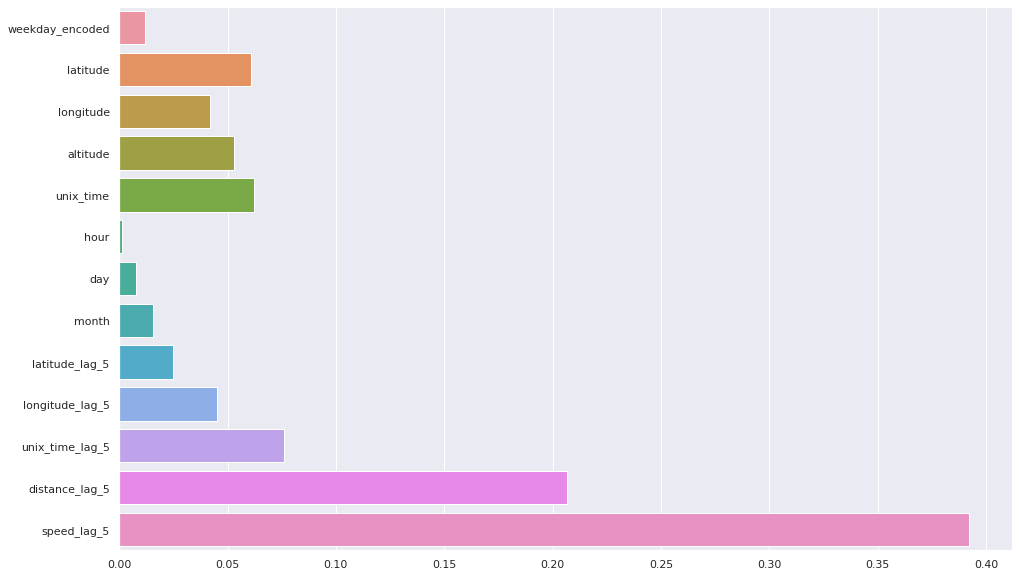

In [114]:
plt.figure(figsize=(16, 10))
tree = pipelineModel.stages[-1]
sns.barplot(x=list(tree.featureImportances), y=assemblerInputs);

And with the help of confusion matrix we can see which mistakes makes model in predictions:

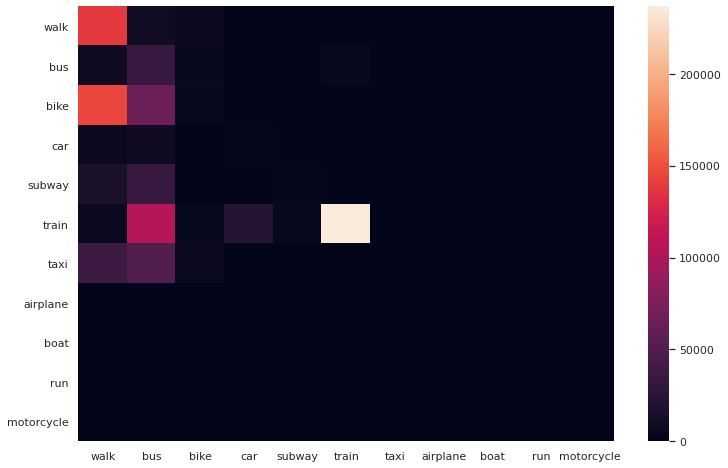

In [115]:
from pyspark.ml.feature import StringIndexer, StringIndexerModel
import numpy as np

labels = {x._java_obj.getOutputCol(): x.labels 
  for x in pipelineModel.stages 
  if isinstance(x, StringIndexerModel)}['label']

nums = len(labels)
index_to_num = dict(zip(range(nums), labels))

confusion_matrix = np.zeros((nums, nums))

errors = pred_df.groupBy(col('label'), col('prediction')).count().collect()
for error in errors:
  confusion_matrix[int(error['label']), int(error['prediction'])] = error['count']

plt.figure(figsize=(12, 8))
ax = sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels);

# Final thoughts

On average I got 45% accuracy and I don't think it is good result.

I think it is due to the complexity of finding the difference in movement between car, bus, taxi or train. Also different people had different GPS navigators, which made additional difficulties.

Also I wanted to show entire feature list that I tried:
- Binned latitude/longitude - useless with Random Forest model.
- Acceleration - almost zero in feature importance.
- Features with lag 10 - Could not add more features with lag because my environment broke.
- Different aggregation functions - almost no changes, but the model trained much longer.
- City where people live - no improvement.



